In [92]:
#TODO: Cluster Universities + Get Mean Values + Reassign to profiles on join

import pandas as pd
import sqlite3
import re, math
from sklearn.cluster import KMeans

def get_type_map(df_column):
    return {t:i for i, t in enumerate(set(df_column))}

conn = sqlite3.connect("profiles.db")
cursor = conn.cursor()
cursor.execute("ATTACH DATABASE 'collegeprofiles.db' AS colleges")

df = pd.read_sql_query("SELECT * from colleges.university_profiles",conn)

dfc = df.drop("school", axis=1)
# CLEAN UNIVERSITY DATA
# drop sat averages
for col in ['sat_math', 'sat_reading', 'sat_writing', 'average_freshman_aid', 'international_percent']:
    dfc = dfc.drop(col, axis=1)
    df = df.drop(col, axis=1)
    

# remove duplicate school column
dfc = dfc.loc[:,~dfc.columns.duplicated()]
df = df.loc[:,~df.columns.duplicated()]

# handle nones in all columns
dfc.fillna(value=pd.np.nan, inplace=True)
df.fillna(value=pd.np.nan, inplace=True)
# remove - in avg_act
dfc['avg_act'] = dfc['avg_act'].map(lambda x: str(x).strip('-'))
df['avg_act'] = df['avg_act'].map(lambda x: str(x).strip('-'))
# cost attendance in state vs out state
dfc['cost_attendance'] = dfc['cost_attendance'].map(lambda x: x[x.find("$")+1:x.find("<")-1] if not isinstance(x,float) else x)
df['cost_attendance'] = df['cost_attendance'].map(lambda x: x[x.find("$")+1:x.find("<")-1] if not isinstance(x,float) else x)
# fix faculty total none as string bug
dfc["faculty_total"] = dfc["faculty_total"].map(lambda x : None if x == "None" else x)
df["faculty_total"] = df["faculty_total"].map(lambda x : None if x == "None" else x)
# weird act nan bug
dfc = dfc[dfc.avg_act != "nan"]
df = df[df.avg_act != "nan"]

dfc = dfc[dfc.avg_act != None]
df = df[df.avg_act != None]

dfc = dfc[dfc.avg_gpa != None]
df = df[df.avg_gpa != None]

dfc = dfc.dropna()
df = df.dropna()

dfc["institution_type"].replace(get_type_map(dfc["institution_type"]), inplace=True)

def getNextTableIndex(index,j):
    isValid = False
    while(not isValid):
        try:
            df['avg_gpa'][index]
            return index, j+1
        except:
            index += 1
            
points = []
i = 0
j=0
while i < 135:
    i, j = getNextTableIndex(i,j)
    point = []
    for col in dfc.columns.values:
        point.append(dfc[col].get(i))
    points.append(point)
    i += 1
        
cluster = KMeans(n_clusters=12, max_iter=500).fit(points)
i = 0
j = 0
while i < 135:
    label = cluster.labels_[j]
    i, j = getNextTableIndex(i,j)
    for c,col in enumerate(dfc.columns.values):
        df.set_value(i, col, cluster.cluster_centers_[label][c])
    i += 1
dfc = df

print(dfc)

                                                school  avg_gpa  avg_act  \
0                                   Bryn Athyn College     3.25  21.9615   
1                                   Adelphi University    3.502     26.2   
2       Albany College of Pharmacy and Health Sciences     3.25  21.9615   
3                              Albertus Magnus College     3.25  21.9615   
4                                     Albright College   3.4995     25.5   
5                                    Alfred University     3.25  21.9615   
6                                    Allegheny College   3.4995     25.5   
7                                   DeSales University     3.25  21.9615   
8                                  Alvernia University     3.25  21.9615   
9                       American International College     3.25  21.9615   
13                                Saint Anselm College   3.4995     25.5   
14                          St. Bonaventure University     3.25  21.9615   
17          

/home/marclane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:83: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [93]:
def convert_class_rank(cr_str):
    cr = cr_str.split(' ')
    return int(cr[0])/int(cr[2])

def convert_sat_to_act(sat):
    if sat >= 2380:
        return 36
    if sat < 2380 and sat >= 2290:
        return 35
    if sat < 2290 and sat >= 2220:
        return 34
    if sat < 2220 and sat >= 2140:
        return 33
    if sat < 2140 and sat >= 2080:
        return 32
    if sat < 2080 and sat >= 2020:
        return 31
    if sat < 2020 and sat >= 1980:
        return 30
    if sat < 1980 and sat >= 1920:
        return 29
    if sat < 1920 and sat >= 1860:
        return 28
    if sat < 1860 and sat >= 1800:
        return 27
    if sat < 1800 and sat >= 1740:
        return 26
    if sat < 1740 and sat >= 1680:
        return 25
    if sat < 1680 and sat >= 1620:
        return 24
    if sat < 1620 and sat >= 1560:
        return 23
    if sat < 1560 and sat >= 1510:
        return 22
    if sat < 1510 and sat >= 1450:
        return 21
    if sat < 1450 and sat >= 1390:
        return 20
    if sat < 1390 and sat >= 1330:
        return 19
    if sat < 1330 and sat >= 1270:
        return 18
    if sat < 1270 and sat >= 1210:
        return 17
    if sat < 1210 and sat >= 1140:
        return 16
    if sat < 1140 and sat >= 1060:
        return 15
    if sat < 1060 and sat >= 990:
        return 14
    if sat < 990:
        return 13

df = pd.read_sql_query("SELECT * from profiles",conn)

# CLEAN INDIVIDUAL PROFILES
# sums profiles sat individual scores and drops them
df['sat_c'] = df['sat_m']+df['sat_r']+df['sat_w']
for col in ['sat_m', 'sat_r', 'sat_w']:
    df = df.drop(col, axis=1)
# converts all sat to act if act is not present
df['act'] = df.apply(lambda x: convert_sat_to_act(x['sat_c'])if pd.isnull(x['act']) else x['act'],axis=1)
# drop nan
df = df.dropna()
# drop class ranks that are not in "1 of 200" format
df = df[df.class_rank.str.match('\d* (of) \d*', na=False)]
# converts class rank to decimal
df['class_rank'] = df['class_rank'].apply(lambda x: convert_class_rank(x))
# convert string label to int

df = pd.merge(dfc, df, left_on = 'school', right_on = 'school')

replace_columns = ['hs_type', 'gender', 'status', 'hs_state', "institution_type"]
df['status'].replace({'Deferred': 'Denied', 'Wait-Listed': 'Denied', 'Will Attend': 'Accepted'}, inplace=True)
for col in replace_columns:
    df[col].replace(get_type_map(df[col]), inplace=True)

df = df.drop('school', axis=1)
print(df)


     avg_gpa  avg_act cost_attendance admission_rate faculty_total  \
0       3.25  21.9615         469.269        73.3846       100.885   
1      3.502     26.2           628.7           66.4         382.3   
2      3.502     26.2           628.7           66.4         382.3   
3      3.502     26.2           628.7           66.4         382.3   
4      3.502     26.2           628.7           66.4         382.3   
5      3.502     26.2           628.7           66.4         382.3   
6      3.502     26.2           628.7           66.4         382.3   
7      3.502     26.2           628.7           66.4         382.3   
8      3.502     26.2           628.7           66.4         382.3   
9      3.502     26.2           628.7           66.4         382.3   
10     3.502     26.2           628.7           66.4         382.3   
11     3.502     26.2           628.7           66.4         382.3   
12     3.502     26.2           628.7           66.4         382.3   
13     3.502     26.

In [94]:
from sklearn.model_selection import train_test_split

X = df.drop('year', axis=1)
X = X.drop('status', axis=1)
X = X.drop('athlete', axis=1)
X = X.drop('sat_c', axis=1)
    
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train))


2373


In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print(X_test)
X_test = scaler.transform(X_test)


      avg_gpa  avg_act cost_attendance admission_rate faculty_total  \
1751    3.715       27          2646.5           49.5          1179   
1165   3.7725    28.75          652.25          29.75        1157.5   
1270   3.7725    28.75          652.25          29.75        1157.5   
2601   3.7725    28.75          652.25          29.75        1157.5   
2971   3.7725    28.75          652.25          29.75        1157.5   
52       3.25  21.9615         469.269        73.3846       100.885   
1786     3.84       28          3277.5           58.5          1637   
1111   3.7725    28.75          652.25          29.75        1157.5   
1013   3.7725    28.75          652.25          29.75        1157.5   
1049   3.7725    28.75          652.25          29.75        1157.5   
2024    3.715       27          2646.5           49.5          1179   
2636  3.37167     22.5          2800.5        66.8333       199.167   
3096     3.84       28          3277.5           58.5          1637   
74    

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/marclane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/marclane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  


In [96]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8),max_iter=1000)


In [97]:
mlp.fit(X_train,y_train)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(8, 8, 8), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [98]:
predictions = mlp.predict(X_test)


In [99]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))


[[556  50]
 [ 99  87]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       606
           1       0.64      0.47      0.54       186

   micro avg       0.81      0.81      0.81       792
   macro avg       0.74      0.69      0.71       792
weighted avg       0.80      0.81      0.80       792



In [100]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
score = logisticRegr.score(X_test, y_test)
print(score)

0.8131313131313131


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


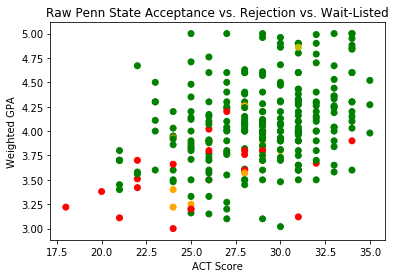

In [91]:
import matplotlib.pyplot as plt

statuses = cursor.execute("SELECT status, act, gpa_w from colleges.university_profiles as c JOIN profiles as p on c.school=p.school where c.school like '%University Park%' and status not like 'will%' and act not like 'None' and gpa_w not like 'None'").fetchall()
colors = {"Accepted":"g", "Denied":"r", "Wait-Listed":"y", "Deferred":"orange"}
x = [t[1] for t in statuses]
y = [t[2] for t in statuses]
c = [colors[t[0]] for t in statuses]
plt.ylabel("Weighted GPA")
plt.xlabel("ACT Score")
plt.title("Raw Penn State Acceptance vs. Rejection vs. Wait-Listed")
plt.scatter(x, y, c=c)

# statuses = cursor.execute("SELECT status, sat_m+sat_r+sat_w, gpa_w from colleges.university_profiles as c JOIN profiles as p on c.school=p.school where c.school like '%University Park%' and status not like 'will%' and act not like 'None' and gpa_w not like 'None'").fetchall()
# colors = {0:"g", 1:"r"}
# x = df['act']
# y = df['gpa_w']
# c = [colors[b] for b in df['status']]
# plt.ylabel("Weighted GPA")
# plt.xlabel("ACT Score")
# plt.title("Predicted Penn State Acceptance vs. Rejection")
# plt.scatter(x, y, c=c)

